In [6]:
###########################################################################
# GOBrien - devito RTM shot  2023
###########################################################################
# libaries 
import numpy as np
import matplotlib . pyplot as plt
import sys
import time
import zarr
from scipy.ndimage.interpolation import shift
from pyrevolve import Revolver

#Devito calls
from devito import configuration
#configuration['log-level'] = 'WARNING'
#configuration['platform'], configuration['compiler'], configuration['language'], configuration['log-level']
from devito.checkpointing import DevitoCheckpoint, CheckpointOperator
from examples.seismic.model import Model
from examples.seismic.acoustic import AcousticWaveSolver
from examples.seismic import AcquisitionGeometry
from devito import Operator, Eq, solve
from examples.seismic import PointSource
from devito import Function, Inc, Dimension
from devito import TimeFunction
from examples.seismic import Receiver

#(a) using one GPU
#(b) using multi-GPUs with MPI (requires turning this notebook into a python script)
#configuration['platform'] = 'nvidiaX'
#configuration['compiler'] = 'pgcc'
#configuration['language'] = 'openacc'
#(c) using one vCPU
#configuration['platform'] = 'cpu64'     # This is default so no need to run it
#configuration['compiler'] = 'custom'   # This is default so no need to run it
#configuration['language'] = 'C'         # This is default so no need to run it
#(d) using multi-vCPUs with OpenMP
configuration['platform'] = 'cpu64'
configuration['compiler'] = 'custom'
configuration['language'] = 'openmp'
print('Starting the job ... ');
###########################################################################
###########################################################################
###########################################################################
# functions
def tic():
    global startTime_for_tictoc
    startTime_for_tictoc = time.time()

def toc():
    if 'startTime_for_tictoc' in globals():
        print("Elapsed time is " + str(time.time() - startTime_for_tictoc) + " s")
    else:
        print("Toc: start time not set")

def ImagingOperatorEIC(model, image):
    # Define the wavefield with the size of the model and the time dimension
    v = TimeFunction(name='v', grid=model.grid, time_order=2, space_order=sp_order)

    u = TimeFunction(name='u', grid=model.grid, time_order=2, space_order=sp_order,save=geometry.nt)

    # Define the wave equation, but with a negated damping term
    eqn = model.m * v.dt2 - v.laplace + model.damp * v.dt.T

    # Use `solve` to rearrange the equation into a stencil expression
    stencil = Eq(v.backward, solve(eqn, v.backward))

    # Define residual injection at the location of the forward receivers
    #dt = model.critical_dt
    geometry.resample(dt)
    residual = PointSource(name='residual', grid=model.grid,
                           time_range=geometry.time_axis,
                           coordinates=geometry.rec_positions)    
    res_term = residual.inject(field=v.backward, expr=residual * dt**2 / model.m)

    # Correlate u and v for the current time step and add it to the image
    image_update=[]
    x, y ,z= image.grid.dimensions
    t = model.grid.stepping_dim

    for ih in range(nh2):
        image_update.append(Inc(image[x,y,z,ih], - u[t,x,y-ih+nh,z]*v[t,x,y+ih-nh,z]))

    return Operator([stencil,image_update] + res_term ,subs=model.spacing_map)

###########################################################################
###########################################################################
###########################################################################


Starting the job ... 


/tmp/ipykernel_1/3366839775.py:10: DeprecationWarning: Please use `shift` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  from scipy.ndimage.interpolation import shift


In [7]:
###########################################################################
#print('Number of arguments:', len(sys.argv), 'arguments.')
#print('Argument List:', str(sys.argv) )

#shot = int(sys.argv[1])
shot=40;

##########################################################################

In [8]:

AZURE_STORAGE_ACCOUNT_NAME="blobtest12345"
AZURE_STORAGE_ACCESS_KEY="xxxx"
container_name1="seismic"
container_name2="shotdata"
container_name3="shotimages"

backend='zarr_blob'


In [9]:
###########################################################################
###########################################################################
# getting parameters - replace with proper par file reader

no=101
figures_on=1
#input_shot='shots/shots'
shift_data=100;
#model_file='models/smmooth_model.zarr'

# output the seismic shots
object_name1="OverTrust_Init"
object_name2="OverTrust_ShotData"

# 0 - write to blob
output_file = 0

# simulation model size and spacing
model_size = (6000,3000,5000)
dx = 12.5
dy = 12.5
dz = 12.5

depthS=20;  #move to headers in zarr
depthR=20;  #move to headers in zarr
t0 = 0.     
tn = 4000  # total time ms
fc = 15/1000  # frequency in kHz
nh = 0
#image_file = 'images/image_py'

###########################################################################
###########################################################################

spacing = (dx, dx, dz)   # dx dy dz spatial sampling
nbl=20;
origin = (0,0,0)
sp_order=4
nh2=2*nh+1

###########################################################################
###########################################################################


opening input file on blob to process OverTrust_ShotData
shotdata
OverTrust_ShotData_shot40
opening traces 
input shot size in cells (4001, 300)


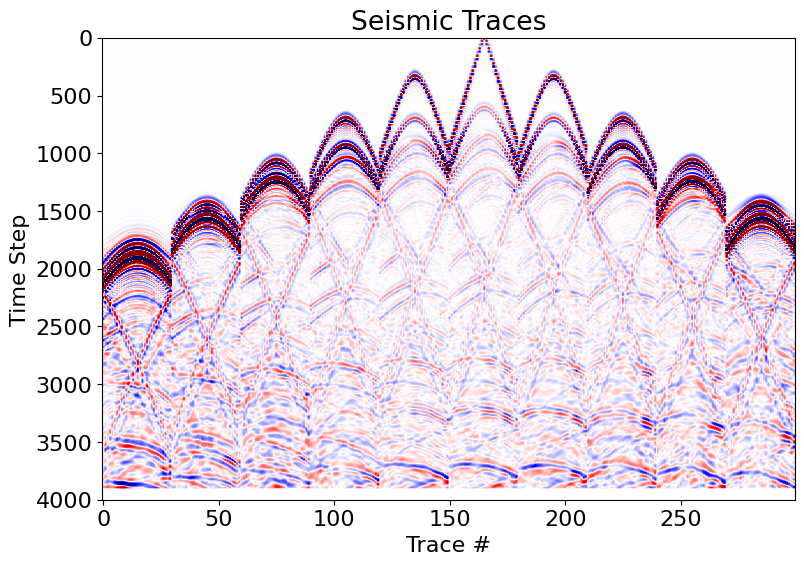

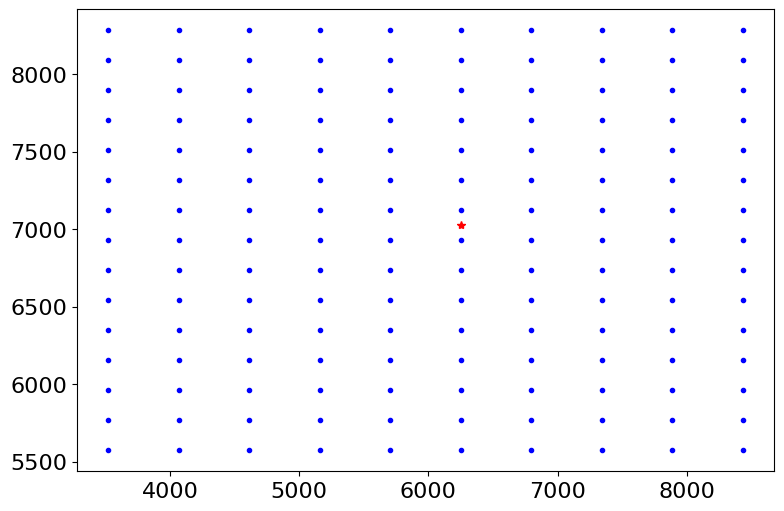

In [10]:
###########################################################################
###########################################################################
# reading traces from cloud blob storage file
###########################################################################
if backend == 'zarr_blob':       
    import azure.storage.blob 
    print('opening input file on blob to process',object_name2)
    
    container_client = azure.storage.blob.ContainerClient(
        account_name=AZURE_STORAGE_ACCOUNT_NAME,
        credential=AZURE_STORAGE_ACCESS_KEY,
        account_url="https://{}.blob.core.windows.net".format(AZURE_STORAGE_ACCOUNT_NAME),
        container_name=container_name2)
    ppp=object_name2+'_shot'+str(shot)
    print(container_name2)
    print(ppp)
    store = zarr.ABSStore(client=container_client, prefix=ppp)
    root = zarr.group(store=store, overwrite=False)
    tzarr=root
    print('opening traces ')

print('input shot size in cells',tzarr.tracesOut.shape)
nt, nr = tzarr.tracesOut.shape
headers = tzarr.headerOut[:][:]
srcX=headers[0,1];
srcY=headers[0,2];
recX=headers[:,3];
recY=headers[:,4];
dt=headers[0,5];

L=int(tn/dt)+1
data = tzarr.tracesOut[0:L][:]
# static shift of forward data for imaging
sval = int(shift_data/dt);
data = shift(data,(-sval,0),cval=0)

if(figures_on==1):
    
    vv = 0.2*np.max(data);
    fig = plt.figure(num=no,figsize=(9, 6)) ;
    plt.clf();
    plt.imshow(data,vmin=-vv,vmax=vv,cmap='seismic');
    #plt.gca().invert_yaxis()
    plt.xlabel('Trace #')
    plt.ylabel('Time Step')
    plt.title(r'Seismic Traces')
    ax = plt.gca()
    ax.set_aspect(0.05)
    #ss="rtm_imgA_py"+str(shot)+".jpeg"
    #plt.savefig(ss,dpi=300);
    
    fig = plt.figure(num=no+1,figsize=(9, 6)) ;
    plt.clf();
    plt.plot(srcX,srcY,'r*')
    plt.plot(recX[::2],recY[::2],'b.')
    #ss="rtm_imgB_py"+str(shot)+".jpeg"
    #plt.savefig(ss,dpi=300);


In [11]:
#open blob velocity model
#################################################################################
if backend == 'zarr_blob':       
    import azure.storage.blob 
    print('opening input file on blob to process',object_name1)
    
    container_client = azure.storage.blob.ContainerClient(
        account_name=AZURE_STORAGE_ACCOUNT_NAME,
        credential=AZURE_STORAGE_ACCESS_KEY,
        account_url="https://{}.blob.core.windows.net".format(AZURE_STORAGE_ACCOUNT_NAME),
        container_name=container_name1)
    store = zarr.ABSStore(client=container_client, prefix=object_name1)
    root = zarr.group(store=store, overwrite=False)
    vzarr=root
    print('opening velocity model')

nilines, nxlines,nsamples = vzarr.volume.shape
nilines, nxlines,nheaders = vzarr.header.shape
ntasks=nilines
print('nil=',nilines, 'nxl=',nxlines, 'ntasks=',ntasks)
nx=nilines
ny=nxlines
nz=nsamples


##############################################################################
###############################################################################
# Loading in velocity model
shape = (int(model_size[0]/spacing[0]) ,int(model_size[1]/spacing[1]) ,int(model_size[2]/spacing[2]) )

print('input model size in cells',vzarr.volume.shape)
print('simulation model size in cells',shape)
shape_full = vzarr.volume.shape

v1 = np.empty(shape,dtype=np.float32)
xx = srcX - model_size[0]*0.5;
yy = srcY - 0.5*model_size[1];
zz = 0;

src_y=0
src_x=0
if(xx<0):
    src_x=xx;
    xx = 0;
if(yy<0):
    src_y=yy;
    yy = 0;

srcX_orig =  srcX;
srcY_orig =  srcY;
transX = srcX_orig - model_size[0]*0.5;
transY = srcY_orig - model_size[1]*0.5;

srcX = model_size[0]*0.5;
srcY = 0.5*model_size[1];
srcZ = depthS 

##########################################################################


opening input file on blob to process OverTrust_Init
opening velocity model
nil= 1600 nxl= 1600 ntasks= 1600
input model size in cells (1600, 1600, 400)
simulation model size in cells (480, 240, 400)


shape= (480, 240, 400)


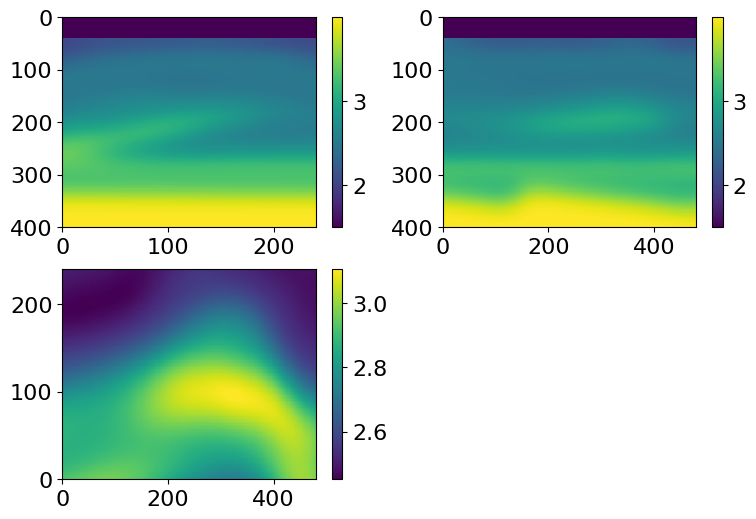

In [12]:
##########################################################################
##########################################################################
# input specific region of the velocity model
      
xxI = int(xx/spacing[0]);
yyI = int(yy/spacing[1]);
zzI = int(zz/spacing[2]);
v1 = vzarr.volume[xxI:xxI+shape[0],yyI:yyI+shape[1],:]

nx,ny,nz=shape
nx,ny,nz=v1.shape
shape=v1.shape
print('shape=',shape)

slx=int(nx/2);
sly=int(ny/2)
slz=int(nz/2)

if(figures_on==1):  
    fig = plt.figure(num=no+2,figsize=(9, 6)) ;
    plt.clf();
    mm = v1[slx,:,:] 
    plt.subplot(221)
    plt.pcolormesh(np.transpose(mm) );#, cmap="RdGy")
    plt.colorbar();
       
    plt.gca().invert_yaxis()  
    mm = v1[:,sly,:] 
    plt.subplot(222)
    plt.pcolormesh(np.transpose(mm));#, cmap="RdGy")
    plt.colorbar();
    plt.gca().invert_yaxis()
    
    mm = v1[:,:,slz] 
    plt.subplot(223)
    plt.pcolormesh(np.transpose(mm));#, cmap="RdGy")
    plt.colorbar();
    #ss="rtm_imgC_py"+str(shot)+".jpeg"
    #plt.savefig(ss,dpi=300);
    

##############################################################################
##########################################################################


In [13]:
##############################################################################
##########################################################################

# Coordinates for model run
src_coordinates1 = np.empty((1, 3)) 
src_coordinates1[0,0] = model_size[0]*0.5 + src_x;
src_coordinates1[0,1] = 0.5*model_size[1] + src_y;
src_coordinates1[0,2] = depthS
       
# Receivers for model run
rec_coordinates1 = np.empty((nr, 3)) 
rec_coordinates1[:,0] = recX[:] - srcX_orig + model_size[0]*0.5 + src_x;
rec_coordinates1[:,1] = recY[:] - srcY_orig + 0.5*model_size[1] + src_y;
rec_coordinates1[:,2] = depthR

          
##############################################################################
##############################################################################

In [14]:
##############################################################################
##############################################################################
# setting up modelling parameters
# running RTM on the single shot    

# model build
model = Model(vp=v1, space_order=sp_order, dtype=np.float32, nbl=nbl,grid=None,shape=shape, origin=origin,spacing=spacing,bcs='damp')
nx, ny, nz = model.vp.shape
print(model.shape)

# Geometry
geometry = AcquisitionGeometry(model,rec_coordinates1,src_coordinates1,t0,tn,f0=fc,src_type='Ricker',tw0=1.5/fc)
# change time step from critical to dt
geometry.resample(dt)
# FD solver definition
solver = AcousticWaveSolver(model, geometry, dt=dt,time_order=2, space_order=sp_order)
#solver.dt=dt;

# set up EIC output volume
d1=spacing[1];
h = Dimension(name='h',spacing=d1)
image_ext=Function(name="grad", dimensions=model.grid.dimensions + (h,), shape = model.grid.shape+( nh2,), grid=model.grid)

op_imaging = ImagingOperatorEIC(model, image_ext)
 
print('Imaging source %d ' % (shot))
t1=time.time()

smooth_d = Receiver(name='rec', grid=model.grid, time_range=geometry.time_axis, coordinates=geometry.rec_positions)
residual = Receiver(name='rec', grid=model.grid, time_range=geometry.time_axis, coordinates=geometry.rec_positions)

u = TimeFunction(name='u', grid=model.grid, time_order=2, space_order=sp_order)
v = TimeFunction(name='v', grid=model.grid, time_order=2, space_order=sp_order)

fwd_op = solver.op_fwd(save=False)
rev_op = solver.op_grad(save=False)
cp = DevitoCheckpoint([u])

residual = PointSource(name='residual', grid=model.grid, time_range=geometry.time_axis,
                           coordinates=geometry.rec_positions) 
#grad, _ = solver.gradient(residual, u=u, dt=dt)
grad = Function(name="grad", grid=model.grid)

wrap_fw = CheckpointOperator(fwd_op, src=solver.geometry.src, u=u, rec=smooth_d,dt=dt, vp=solver.model.vp)
wrap_rev = CheckpointOperator(rev_op, u=u, v=v,rec=residual, grad=grad,dt=dt, vp=solver.model.vp)

nt=geometry.nt-3;
n_checkpoints=10
wrp = Revolver(cp, wrap_fw, wrap_rev, n_checkpoints, nt, compression_params=None)
wrp.apply_forward()


# Compute gradient from data residual and update objective function
residual.data[:] = 0*smooth_d.data[:] - data
#objective = .5*np.linalg.norm(residual.data.ravel())**2
wrp.apply_reverse()

#image_update=[]
#x, y ,z= image_ext.grid.dimensions
#t = model.grid.stepping_dim

t2=time.time();
print('time for 1 shot',str(t2-t1))
lx,ly,lz = grad.shape

image_ext = grad.data[nbl:lx-nbl,nbl:ly-nbl,nbl:lz-nbl]
print('image size',image_ext.shape,' nz= ',nz)

for i in range (0,nz-2*nbl):
    image_ext[:,:,i] = image_ext[:,:,i] * i * i

#######################################################################################

Operator `initdamp` ran in 0.07 s
Trying to allocate more memory for symbol u than available on physical device, this will start swapping


(480, 240, 400)
Imaging source 40 
time for 1 shot 1423.5613996982574
image size (480, 240, 400)  nz=  440


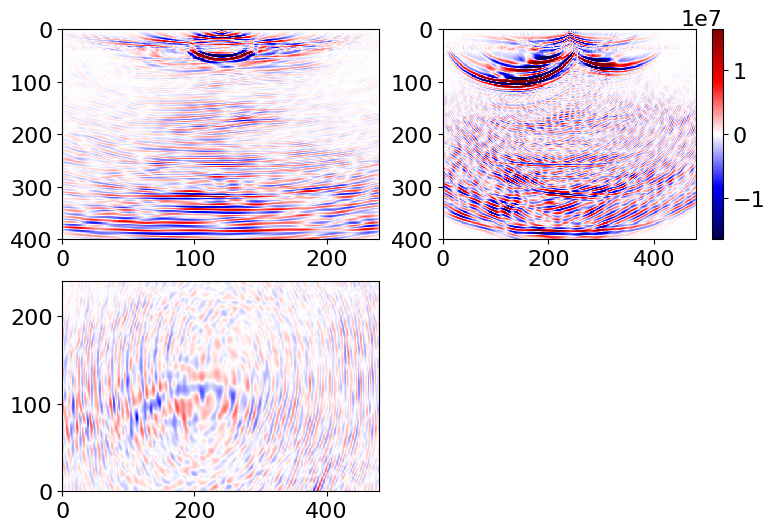

In [15]:
###############################################################################

if(figures_on==1):  
    fig = plt.figure(num=no+3,figsize=(9, 6)) ;
    vv = 0.2*np.max(image_ext.data);

    plt.clf();
    mm = image_ext[slx,:,:]
    plt.subplot(221)
    plt.pcolormesh(np.transpose(mm),vmin=-vv,vmax=vv,cmap='seismic' );#, cmap="RdGy")
    #plt.colorbar();
       
    plt.gca().invert_yaxis()  
    mm = image_ext[:,sly,:]
    plt.subplot(222)
    plt.pcolormesh(np.transpose(mm),vmin=-vv,vmax=vv,cmap='seismic');#, cmap="RdGy")
    plt.colorbar();
    plt.gca().invert_yaxis()
    
    #mm = image_ext.data[:,:,slz+nbl,nh] 
    mm=[];
    mm = image_ext[:,:,slz]
    plt.subplot(223)
    plt.pcolormesh(np.transpose(mm),vmin=-vv,vmax=vv,cmap='seismic');#, cmap="RdGy")
    #plt.colorbar();
     
    #mm=[];
    #mm = image_ext[slx,sly,:]
    #plt.subplot(224)
    #plt.pcolormesh(mm,vmin=-vv,vmax=vv,cmap='seismic' );#, cmap="RdGy")
    #plt.colorbar();
    #plt.gca().invert_yaxis()

    #ss="rtm_imgD_py"+str(shot)+".jpeg"
    #plt.savefig(ss,dpi=300);
    
###############################################################################


In [16]:
##############################################################################
if(output_file==0):
    import azure.storage.blob
    container_client = azure.storage.blob.ContainerClient(
        account_name=AZURE_STORAGE_ACCOUNT_NAME,
        credential=AZURE_STORAGE_ACCESS_KEY,
        account_url="https://{}.blob.core.windows.net".format(AZURE_STORAGE_ACCOUNT_NAME),
        container_name=container_name3)
    ppp=object_name2+'_image'+str(shot)
    print(container_name3)
    print(ppp)
    store = zarr.ABSStore(client=container_client, prefix=ppp) 
    root = zarr.group(store=store, overwrite=True)
    shape_traces=image_ext.shape
    shape_header = 1, 6  
    imageOut = root.zeros('imageOut', compressor='none', shape=shape_traces, dtype=np.float32)
    headerOut = root.zeros('headerOut', compressor='none', shape=shape_header, dtype=np.float32)
    
    headers = np.empty(shape_header,dtype=np.float32)
    for i in range (0,1):
        headers[i,0] = shot
        headers[i,1] = srcX_orig
        headers[i,2] = srcY_orig
        headers[i,3] = dx
        headers[i,4] = dy
        headers[i,5] = dz

    headerOut[:,:] = headers
    imageOut[:,:,:] = image_ext[:,:,:]

##############################################################################


shotimages
OverTrust_ShotData_image40
